[Open these notes in Google Colab.](https://colab.research.google.com/github/middlebury-csci-0451/CSCI-0451/blob/main/lecture-notes/image_classification_in_practice.ipynb) 

[Open the live version of these notes in Google Colab.](https://colab.research.google.com/github/middlebury-csci-0451/CSCI-0451/blob/main/lecture-notes/image_classification_in_practice-live.ipynb) 

In this lecture, we'll wrap up our discussion of deep image classification with consideration of some of the practicalities that go in to designing and training models. We'll focus especially on some methods that can improve the performance of image classifiers without necessarily increasing the size of the training data set. These are *data augmentation* and *transfer learning*. 

In [1]:
# for data retrieval
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# for managing image data
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models

# various torch stuff
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import torch

# for timing the training loop
import time

torch.random.manual_seed(12345) # for reproducibility

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Task for Today

Can you teach a machine learning algorithm to distinguish between pictures of dogs and pictures of cats?

According to this helpful diagram below, one way to do this is to attend to the visible emotional range of the pet:

![](https://static.boredpanda.com/blog/wp-content/uploads/2017/09/funny-cats-vs-dogs-comics-200-59c380533523b__700.jpg)

Unfortunately, using this method requires that we have access to multiple images of the same individual. We will consider a setting in which we have only one image for pet. Can we reliably distinguish between cats and dogs in this case?

## Data Preparation

We'll start by downloading a data set containing images of cats and dogs. The result is a folder in our working directory called `cats_and_dogs_filtered`. This folder contains a `train` directory consisting of training images and a `validation` directory with validation images. Within the `train` directory are `cats` and `dogs` subdirectories containing images of each kind, and similarly for the `validation` directory. 

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

with urlopen(URL) as zipped:
    with ZipFile(BytesIO(zipped.read())) as zfile:
        zfile.extractall('')

train_dir = "cats_and_dogs_filtered/train"
val_dir   = "cats_and_dogs_filtered/validation"

Now that we've acquired the data, let's create a Torch `Dataset` object. The nice developers at `Torch` have implemented an `ImageFolder` constructor that will create a `Dataset` for us. We only need to supply the directory of the training (and validation) data sets, as well as an optional `transform` that should be applied to each image prior to being fed into the model. Let's start by just specifying that each image should have the `transforms.ToTensor()` function applied to it, which, as you might guess, will convert the image into a `Tensor`: 

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Now we're ready to visualize a few entries in our data: 

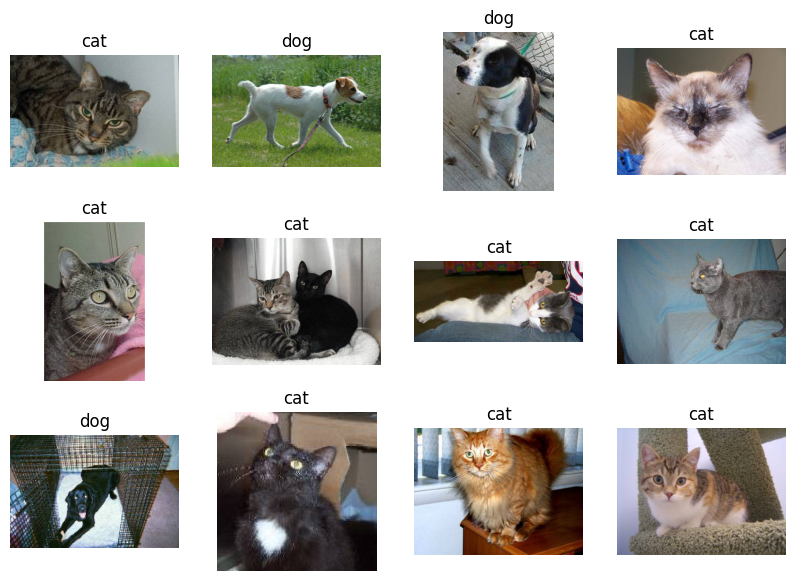

In [4]:
from matplotlib import pyplot as plt
import numpy as np

def viz_data(data, n_rows = 3, n_cols = 4):
    classes = ("cat", "dog")
    fig, axarr = plt.subplots(n_rows, n_cols, figsize = (10, 7))
    for i, ax in enumerate(axarr.ravel()):
        
        j = np.random.randint(0, 2000)
        # returns batch_size images with their labels
        X, y = train_data[j]

        # populate a row with the images in the batch
        for j in range(n_cols):
            img = np.moveaxis(X.numpy(), 0, 2) 
            ax.imshow(img )
            ax.axis("off")
            ax.set(title = classes[int(y)])

viz_data(train_data)

Although the classification task of "cat" vs. "dog" is simpler than last time, we can also see that the dat is somewhat messier. In particular, the images appear to come from a larger variety of different contexts. An important technical problem is that the images are of different *sizes*. In the supervized learning context this corresponds to a different number of features for each image, which is not workable for modeling. So, we need to resize our images to ensure that they all have the same number of features. This is handled by the `Resize` transform. The `Normalize` transform services to make the pixel values more comparable to each other (more formally, it scales the pixel values so that each image has mean pixel value 0 and variance 1). 

Let's define both our training and validation data sets with this new set of transforms: 

In [5]:


train_data = ImageFolder(train_dir, transform = transform)
val_data = ImageFolder(val_dir, transform = transform)

If we now take a look, we can see that the resulting images are now all the same size, although some of them are a little blurry and others might be cropped in slightly strange ways. 

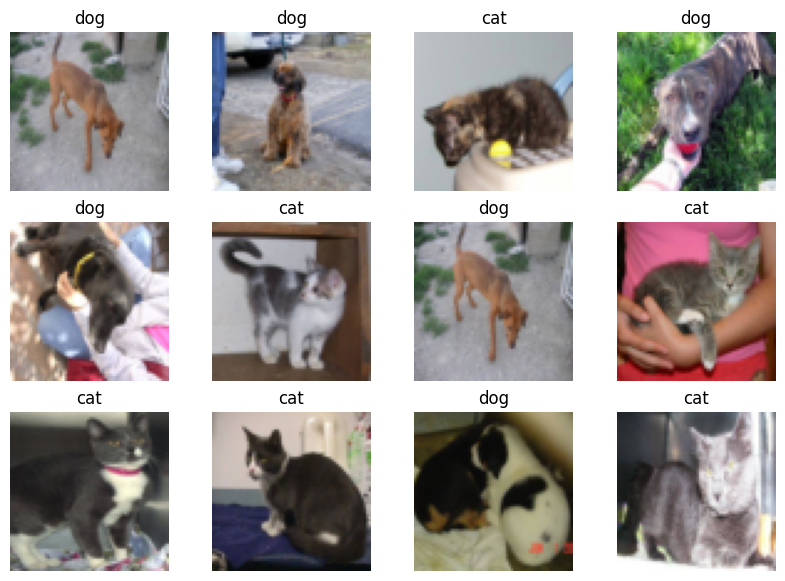

In [6]:
viz_data(train_data)

## Modeling

Now that we've prepared our data, we are ready to construct a model. First let's wrap our data sets in data loaders to handle batching and randomization during training: 

For a first model, let's use a manual convolutional neural network with three convolutional layers. This network is very similar to the one that we introduced last lecture. 

Let's inspect our model: 

In [9]:
INPUT_SHAPE = (3, 64, 64)
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 60, 60]           7,600
         MaxPool2d-2          [-1, 100, 30, 30]               0
            Conv2d-3           [-1, 50, 28, 28]          45,050
         MaxPool2d-4           [-1, 50, 14, 14]               0
            Conv2d-5           [-1, 20, 12, 12]           9,020
         MaxPool2d-6             [-1, 20, 6, 6]               0
            Linear-7                   [-1, 80]          57,680
            Linear-8                   [-1, 40]           3,240
            Linear-9                   [-1, 10]             410
Total params: 123,000
Trainable params: 123,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.84
Params size (MB): 0.47
Estimated Total Size (MB): 4.35
-------------------------------------------

This is plenty of parameters, but again not as many as we might expect from a model with a similar number of layers with more fully-connected (`Linear`) layers. 

Now we can define a training loop and train our model. As usual, the training loop contains just a few important computational steps: 

1. Extract a batch of data from the `data_loader`. 
2. Zero out the previously-computed gradients. 
3. Compute the model predictions on the predictor data in the batch. 
4. Compute the loss of these predictions relative to the ground-truth labels. 
5. Compute gradients of the batch loss with respect to the model parameters. 
6. Take a step in the direction of the gradient, possibly after some modifications (e.g. in the Adam algorithm). 

In [10]:
def train(model,  data_loader, optimizer, k_epochs = 1, print_every = 2000):

    begin = time.time()
    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss() 

    # optimizer is Adam, which does fancier stuff with the gradients
    
    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
                print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], training loss: {running_loss / print_every:.3f}')
                running_loss = 0.0
    end = time.time()
    print(f'Finished training in {round(end - begin)}s')

Now let's try training our model: 

[epoch: 1, batches:    50], training loss: 1.042
[epoch: 1, batches:   100], training loss: 0.698
[epoch: 2, batches:    50], training loss: 0.704
[epoch: 2, batches:   100], training loss: 0.699
[epoch: 3, batches:    50], training loss: 0.701
[epoch: 3, batches:   100], training loss: 0.699
[epoch: 4, batches:    50], training loss: 0.691
[epoch: 4, batches:   100], training loss: 0.705
[epoch: 5, batches:    50], training loss: 0.702
[epoch: 5, batches:   100], training loss: 0.702
Finished training in 40s


These are not *very* impressive training loss scores, as the loss we would get for a model that put equal weight on each possible label (essentially shrugging its shoulders) would be 

In [12]:
print(np.log(2))

0.6931471805599453


However, we can still test the model and see whether it might have learned anything that enables better-than-random predictions: 

In [13]:
def test(model, data_loader):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            # run all the images through the model
            y_hat = model(X)

            # the class with the largest model output is the prediction
            _, predicted = torch.max(y_hat.data, 1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f'Test accuracy: {100 * correct // total} %')

test(model, val_loader)

Test accuracy: 52 %


So, our model did learn some signal that was useful in making predictions on the validation set, even though that wasn't totally visible from the values of the training loss. 

## Data Augmentation

One of the most common problems in applied machine learning is: 

> *I don't have enough data to train my model.* 

Sometimes, in this situation, we are simply out of luck: if there's not enough data then you need to train a simpler model, or go get more data. In some settings---especially in the setting of images---there are some techniques we can try. The first one is data augmentation. 

Data augmentation techniques usually exploit certain so-called *invariances* in image data. Here's an example of "rotation invariance." Suppose I show you a picture of a cat: 

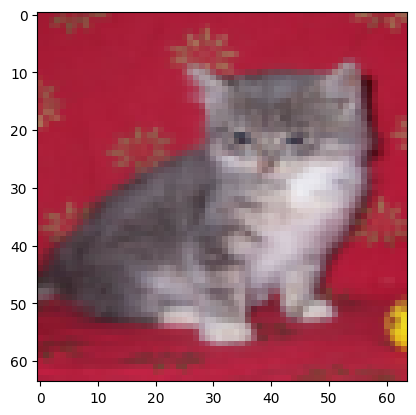

In [14]:
X, y = train_data[14]
plt.imshow(np.moveaxis(X.numpy(), 0, 2))

Now suppose that I *rotate* the image a bit:

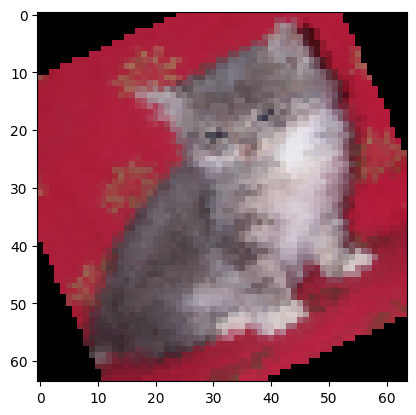

In [15]:

plt.imshow(np.moveaxis(rotated.numpy(), 0, 2))

Well, that rotated image is *still an image of a cat*, just rotated a little bit. So, the correct label of the image is "rotation-invariant": rotating the image doesn't change the correct label. I could similarly flip the image upside-down, or crop it, or manipulate it in many other ways while still preserving it's "cat"-ness. So, and this is a very special kind of circumstances, I can (sort of) *get more data for free* by rotating, flipping, and otherwise manipulating my images. 

This cluster of techniques is called *data augmentation*. Theoretically, data augmentation is not *just* a hack to get "more" data; it also helps models to generalize by ensuring that they are really learning features of "cats" and not just "cats that are standing the right way up." 

A nice feature of Torch is that we can build these transforms right into our training data set. We don't apply data augmentation to our validation data. 

In [16]:


train_data = ImageFolder(train_dir, transform = augmentation_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

Let's take a look at some of our transformed data: 

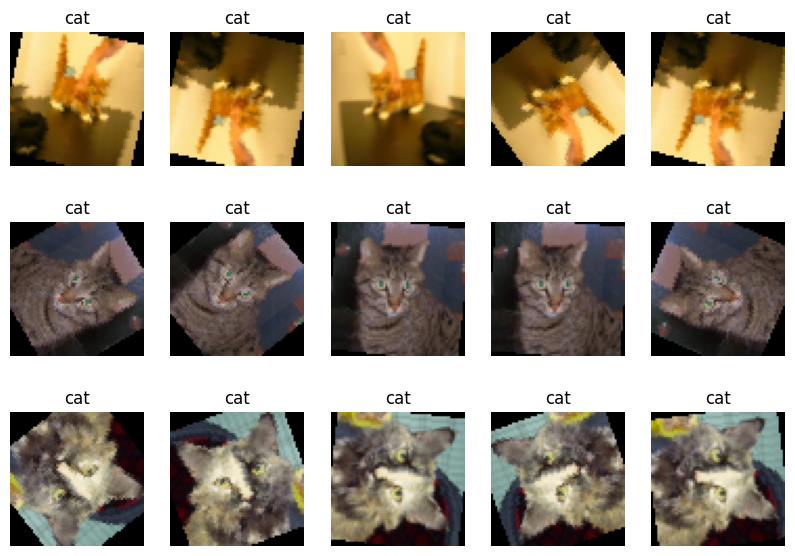

In [17]:
classes = ("cat", "dog")

n_rows = 3
n_cols = 5

fig, axarr = plt.subplots(n_rows, n_cols, figsize = (10, 7))

for i in range(n_rows):
    for j in range(n_cols):
    # returns batch_size images with their labels
        X, y = train_data[i]

        img = np.moveaxis(X.numpy(), 0, 2) 
        axarr[i, j].imshow(img )
        axarr[i, j].axis("off")
        axarr[i, j].set(title = classes[int(y)])

There are many other possible transformations, but we'll stick with just those for now. Let's go ahead and train! 

In [18]:
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimizer, k_epochs = k_epochs, print_every = 50)
test(model, val_loader)

[epoch: 1, batches:    50], training loss: 0.968
[epoch: 1, batches:   100], training loss: 0.710
[epoch: 2, batches:    50], training loss: 0.699
[epoch: 2, batches:   100], training loss: 0.700
[epoch: 3, batches:    50], training loss: 0.699
[epoch: 3, batches:   100], training loss: 0.701
[epoch: 4, batches:    50], training loss: 0.708
[epoch: 4, batches:   100], training loss: 0.697
[epoch: 5, batches:    50], training loss: 0.699
[epoch: 5, batches:   100], training loss: 0.704
Finished training in 50s
Test accuracy: 50 %


Why did this model do worse than the last one even though we introduced a cool new technique? One way to think about this is that applying data augmentation increases the "effective size" of the data. However, we haven't given the model any more epochs for training. So, the model still only sees each image 5 times, just randomly modified. The model can't learn as much as it needs to from each image in this small number of epochs, and so it performs worse. It is likely that, with more epochs, this model would eventually be able to outperform the previous one. 

## Transfer Learning

*Transfer learning* is a fancy term that was invented to make it sound respectable to mooch off the work and computatinoal power of others. 

This is not quite fair. When we do *transfer learning,* we use a pre-trained model, modify it, and train it a little bit more for our own task. Generally speaking, models that have been trained on tasks similar to the ones we are doing now are likely to have the best performance. 

For example, `ImageNet` is a well-known class of models trained for image classification tasks. `Torch.models` allows you to simply create an instance of an `ImageNet` model: 

We can immediately see that this model is *much* more complex than anything we have worked with before. There are over 11M parameters! 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

One important point we can discover from the summary is that the final `Linear` layer, which serves as the model output, has 1,000 components. This is because the model was originally trained to classify images with 1,000 different possible labels. This won't work for us, since we only have two categories. What we'll do is: 

1. Assume that the patterns that `ImageNet` has learned are stored in the many hidden layers and
2. Replace the output layer with our own output layer with just two output components. 

In this model, the output layer is stored in the `fc` instance variable. So, let's just overwrite it, making sure to include the correct number of input features; 

Now we (hopefully) have a model that maintains much of `ImageNet`'s ability to detect patterns in images, but which will work for our purposes of binary classification. Let's go ahead and train it! 

In [22]:
# train with the complete model
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimizer, k_epochs = k_epochs, print_every = 50)
test(model, val_loader)

[epoch: 1, batches:    50], training loss: 0.995
[epoch: 1, batches:   100], training loss: 0.649
[epoch: 2, batches:    50], training loss: 0.639
[epoch: 2, batches:   100], training loss: 0.618
[epoch: 3, batches:    50], training loss: 0.576
[epoch: 3, batches:   100], training loss: 0.607
[epoch: 4, batches:    50], training loss: 0.571
[epoch: 4, batches:   100], training loss: 0.608
[epoch: 5, batches:    50], training loss: 0.581
[epoch: 5, batches:   100], training loss: 0.549
Finished training in 58s
Test accuracy: 71 %


After just two training epochs, our `ImageNet`-based classifier is already able to do substantially better on the validation set than our hand-crafted model did under either training approach. 

One way to think about this: we only have the data (and compute power) we have, but transfer learning can allow us to benefit from the data (and compute power) that others have used in their own projects. 

## Fixing Parameters

But wait! In the last experiment, we still needed to train all 11M parameters of our modified `ImageNet`. But maybe we don't even need to train the parameters of the intermediate hidden layers. Let's instead train our model by insisting that only the parameters of the final hidden layer are going to be updated, with all the other parameters staying the same. 

In [23]:
# instead train only the parameters of the final layer
# can be around 50% faster

model = models.resnet18(weights='IMAGENET1K_V1')
model = model.to(device)

# no gradients for any of the model parameters, so no updates


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [24]:
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

Now, although our model still has the same number of parameters, the number of *trainable* parameters is much smaller. This means that we can get away with much less computation when it comes time to perform gradient updates. In particular, when using automatic differentiation it typically requires about as much compute to form the gradient (the backward step) as it does to compute the loss (the forward step). So, if we skip most of the backward step, we can hope for our training to be roughly twice as fast. This is usually the case for very large models. Our model isn't quite big enough to realize that large a speedup. 

In [25]:
train(model, train_loader, optimizer, k_epochs = k_epochs, print_every = 50)
test(model, val_loader)

[epoch: 1, batches:    50], training loss: 0.761
[epoch: 1, batches:   100], training loss: 0.711
[epoch: 2, batches:    50], training loss: 0.662
[epoch: 2, batches:   100], training loss: 0.667
[epoch: 3, batches:    50], training loss: 0.634
[epoch: 3, batches:   100], training loss: 0.632
[epoch: 4, batches:    50], training loss: 0.633
[epoch: 4, batches:   100], training loss: 0.665
[epoch: 5, batches:    50], training loss: 0.674
[epoch: 5, batches:   100], training loss: 0.615
Finished training in 48s
Test accuracy: 63 %


It's important to keep in mind that none of these models were even *close* to being fully trained. Running a complete training process would be too much to show in a live demo! But the results here should be taken as illustrative of some of the benefits of the demonstrated modeling techniques, rather than scientific comparisons.  

![](../assets/img/memes/class-cats.jpeg)